In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


**Importing necessary libraries**

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

**Loading the training dataset**

In [9]:
train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
train_df = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

**Analysing the training dataset**

In [10]:
print(train_df.describe())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  


In [11]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


In [12]:
print(train_df.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64


**Loading the test dataset**

In [13]:
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_df = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_df.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


**Visualising the dataset**

Text(0, 0.5, 'Genre')

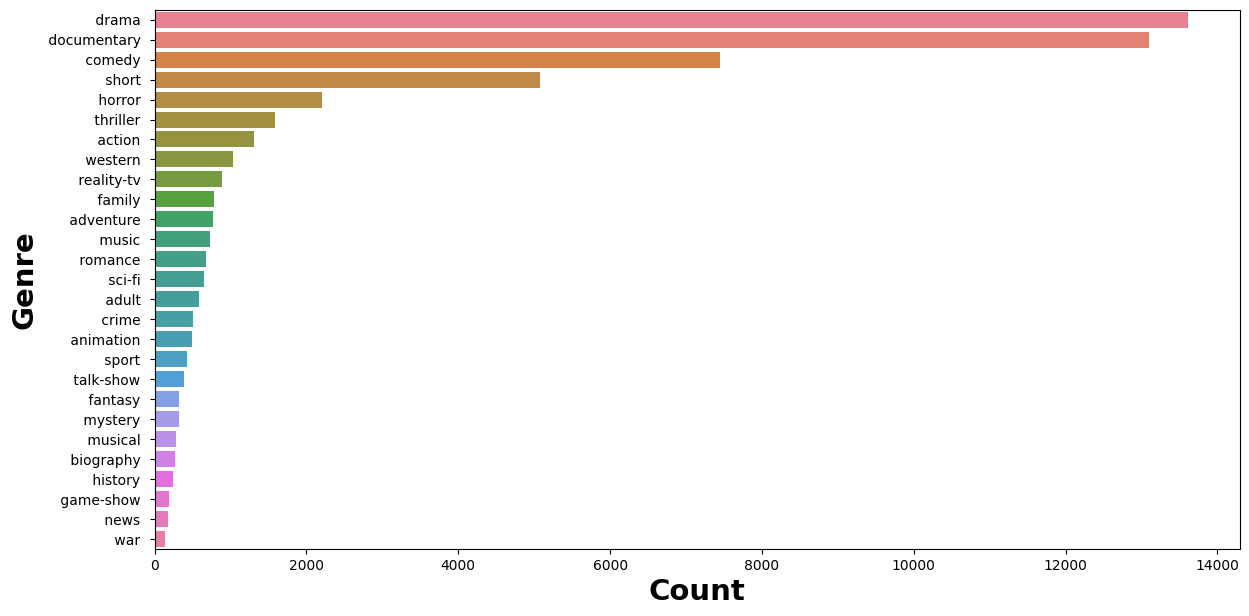

In [14]:
plt.figure(figsize=(14, 7))
sns.countplot(data=train_df, y='Genre', order=train_df['Genre'].value_counts().index, palette='husl')
plt.xlabel('Count', fontsize=21, fontweight='bold')
plt.ylabel('Genre', fontsize=21, fontweight='bold')

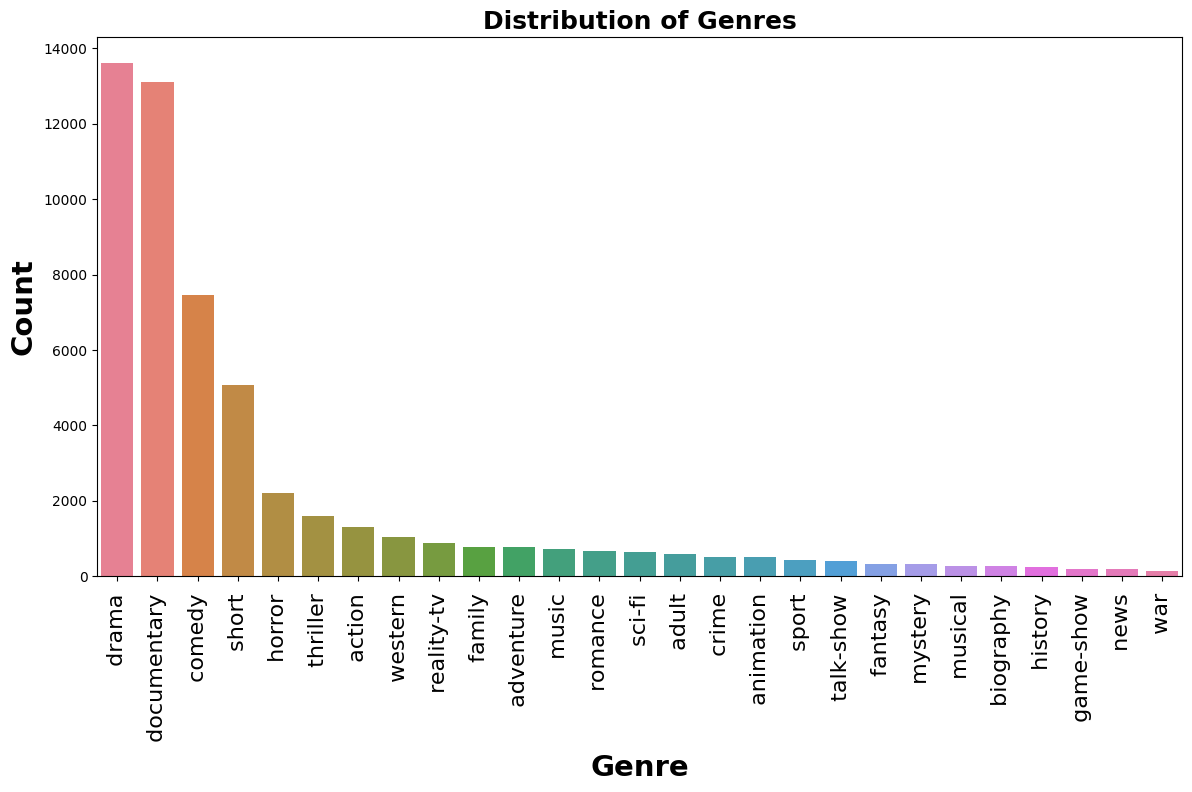

In [15]:
plt.figure(figsize=(14, 7))
counts = train_df['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='husl')
plt.xlabel('Genre', fontsize=21, fontweight='bold')
plt.ylabel('Count', fontsize=21, fontweight='bold')
plt.title('Distribution of Genres', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=16)
plt.show()

**Initializing the stemmer and the stop words**

In [17]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

**Defining the clean_text function**

In [18]:
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

**Applying the clean_text function to the 'Description' column in the training and test data**

In [19]:
train_df['Text_cleaning'] = train_df['Description'].apply(clean_text)
test_df['Text_cleaning'] = test_df['Description'].apply(clean_text)

**Calculating the length of cleaned text**

In [20]:
train_df['length_Text_cleaning'] = train_df['Text_cleaning'].apply(len)

**Visualizing the distribution of text lengths**

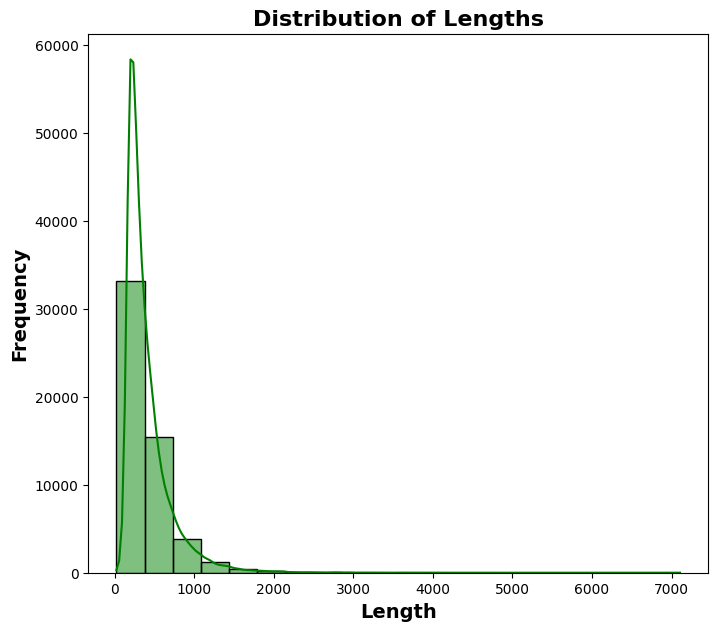

In [21]:
plt.figure(figsize=(8, 7))
sns.histplot(data=train_df, x='length_Text_cleaning', bins=20, kde=True, color='green')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

**Initializing the TF-IDF vectorizer**

In [22]:
tfidf_vectorizer = TfidfVectorizer()

**Fitting and transforming the training data**

In [23]:
X_train = tfidf_vectorizer.fit_transform(train_df['Text_cleaning'])

**Transforming the test data**


In [24]:
X_test = tfidf_vectorizer.transform(test_df['Text_cleaning'])

**Splitting the data into training and validation sets**

In [25]:
X = X_train
y = train_df['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Initializing and training a Multinomial Naive Bayes classifier**

In [27]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

**Making predictions on the validation set**

In [28]:
y_pred = classifier.predict(X_val)

**Evaluate the performance of the model**

In [29]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Using the trained model to make predictions on the test data**

In [30]:
X_test_predictions = classifier.predict(X_test)
test_df['Predicted_Genre'] = X_test_predictions

**Saving the test_data DataFrame with predicted genres to a CSV file**

In [31]:
test_df.to_csv('predicted_genres.csv', index=False)

**Displaying the 'test_data' DataFrame with predicted genres**

In [33]:
test_df.head()

,Id,Title,Description,Text_cleaning,Predicted_Genre
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama
